# This notebook uses all the script to train a CAE for DNase

In [76]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import json
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
testing = True
    
# The base directory is one level up
base = '..'
settings_filepath = (
    '../settings-grch38-dnase-12kb-testing.json'
    if testing
    else '../settings-grch38-dnase-12kb.json'
)
cnn_search_filepath = '../cnn-search.json'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load settings

In [77]:
with open(settings_filepath, "r") as f:
    settings = json.load(f)

with open(cnn_search_filepath, "r") as f:
    search = json.load(f)

### 1. Find DNase datasets on ENCODE

In [78]:
from find import find

datasets_filepath = find(settings, base=base, clear=True, verbose=True)

Search for experiments... done!
Found 727 human DNase-seq experiments
Download metadata... done!
Removed 69 experiments due to auditing errors
Found 637 experiments comprising 637 datasets
Saved dataset accessions to ../datasets-grch38-dnase-2019-02-07.json


In [79]:
# Comment out or remove the following line. It's only used for testing
datasets_filepath = '../datasets-grch38-dnase-testing.json' if testing else datasets_filepath
with open(datasets_filepath, "r") as f:
    datasets = json.load(f)
    dataset_ids = list(datasets.keys())

### 2. Download the datasets

In [80]:
from download import download

download(datasets, settings, base=base, clear=False, verbose=True)

The data will be downloaded to `../data`.

### 3. Create jobs for preparing all the datasets

In [63]:
from prepare import prepare_jobs

prepare_jobs(
    'DNase',
    os.path.relpath(datasets_filepath, base),
    os.path.relpath(settings_filepath, base),
    base=base,
    clear=True,
    verbose=False,
)

Created slurm file for preparing 2 datasets


The slurm files for the individual preparation will be located in `prepare`.

### 3.5 Test data preparation

In [81]:
from prepare import prepare

prepare(
    'DNase',
    datasets,
    settings,
    # single_dataset='ENCSR320PGJ',
    base=base,
    clear=False,
    verbose=False,
)

Train data shape: (5698, 120, 1)
Train peaks shape: (5698,) num windows with peaks 2872 (50.40%)
Dev data shape: (503, 120, 1)
Dev peaks shape: (503,) num windows with peaks 238 (47.32%)
Test data shape: (503, 120, 1)
Test peaks shape: (503,) num windows with peaks 242 (48.11%)
88 (1.54%) out of 5698 windows are empty


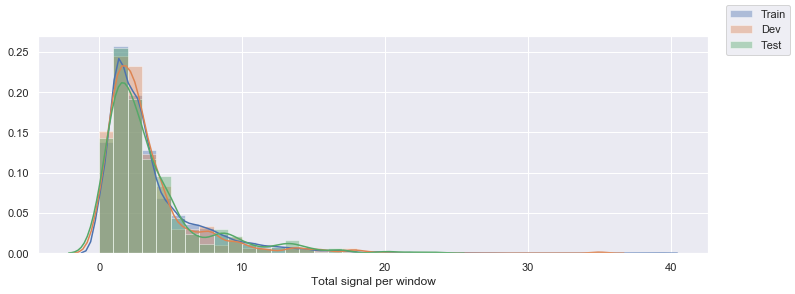

In [57]:
"""Sanity check that the normalization really worked"""

from ae.utils import plot_total_signal

plot_total_signal('ENCSR320PGJ', base=base)

In [89]:
"""Merge data"""

from merge import merge

merge(
    datasets,
    settings,
    base=base,
    clear=False,
    verbose=False
)

(481, 120, 1) (481, 120, 1)
(481, 120, 1) (481, 120, 1)
(5450, 120, 1) (5951, 120, 1)
(962, 120, 1) (525, 120, 1)
(962, 120, 1) (526, 120, 1)
(5450,) (5951,)
(1487, 120, 1) (525, 120, 1)
(1488, 120, 1) (526, 120, 1)
(11401, 120, 1) (4177, 120, 1)
(2012, 120, 1) (369, 120, 1)
(2014, 120, 1) (369, 120, 1)
(11401,) (4177,)
(2381, 120, 1) (369, 120, 1)
(2383, 120, 1) (369, 120, 1)
(15578, 120, 1) (5090, 120, 1)
(2750, 120, 1) (449, 120, 1)
(2752, 120, 1) (450, 120, 1)
(15578,) (5090,)
(3199, 120, 1) (449, 120, 1)
(3202, 120, 1) (450, 120, 1)


### 4. Create jobs for training various CAE models

In [75]:
from jobs import jobs

jobs(
    search,
    os.path.relpath(datasets_filepath, base),
    os.path.relpath(settings_filepath, base),
    epochs=25,
    batch_size=32,
    peak_weight=1,
    base=base,
    clear=True,
    verbose=False
)


Created slurm file for training 218 neural networks


### 5. Test CAEs training

In [90]:
model_name = 'cf-128--ck-11--du-512-128--do-0-0-0--e-10--rl-0--o-adam--lr-0.01--lrd-0.0--l-bce--m-'

In [97]:
settings

{'coord_system': 'GRCh38',
 'assay_type': 'DNase-seq',
 'data_types': {'rdn_signal': 'read-depth normalized signal',
  'narrow_peaks': 'peaks',
  'broad_peaks': 'hotspots'},
 'file_types': {'rdn_signal': 'bigWig',
  'narrow_peaks': 'bigBed',
  'broad_peaks': 'bigBed'},
 'encode_file_types': {'rdn_signal': 'bigWig',
  'narrow_peaks': 'bigBed+narrowPeak',
  'broad_peaks': 'bigBed+broadPeak'},
 'window_size': 12000,
 'step_frequency': 2,
 'resolution': 100,
 'chromosomes': ['chr21', 'chr22'],
 'dev_set_size': 0.075,
 'test_set_size': 0.075,
 'percentile_cutoff': [0, 99.9],
 'rnd_seed': 123,
 'incl_pctl_total_signal': 25,
 'incl_pct_no_signal': 5}

In [98]:
from train import train

# Load the CAE definition, training settings, datasets, and define training parameters
with open('../models/{}.json'.format(model_name), 'r') as f:
    definition = json.load(f)

epochs = 10
batch_size = 32
peak_weight = 1 # Is not used right now

# Start the training
train(
    settings,
    dataset_ids,
    definition,
    epochs=epochs,
    batch_size=batch_size,
    peak_weight=peak_weight,
    base=base,
    clear=True
)

KeyboardInterrupt: 

In [102]:
from train import train_on_merged

# Load the CAE definition, training settings, datasets, and define training parameters
with open('../models/{}.json'.format(model_name), 'r') as f:
    definition = json.load(f)

epochs = 10
batch_size = 32
peak_weight = 1 # Is not used right now

# Start the training
train_on_merged(
    definition,
    settings,
    epochs=epochs,
    batch_size=batch_size,
    peak_weight=peak_weight,
    base=base,
    clear=True,
    train_on_hdf5=True,
)

(20668, 120, 1)


KeyboardInterrupt: 

#### Visualize training and validation loss

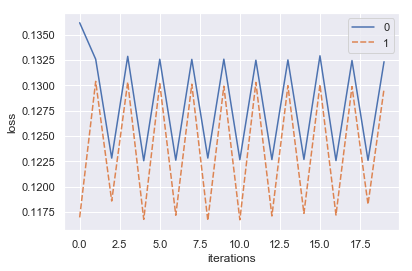

In [53]:
import h5py
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

with h5py.File(
    os.path.join(base, 'models', '{}---training.h5'.format(model_name)), 'r'
) as f:
    data = np.zeros((f['loss'].shape[0], 2))
    data[:,0] = f['loss'][:]
    data[:,1] = f['val_loss'][:]

    ax = sns.lineplot(data=pd.DataFrame(data))
    ax.set(xlabel='iterations', ylabel='loss')

### 6. Evaluate CAEs

In [31]:
from evaluate import evaluate

evaluate(
    model_name,
    datasets,
    base=base,
    clear=True
)